In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.atomic.features as fs
import socceraction.atomic.labels as lab

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
## Configure file and folder names
datafolder = "../data"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
features_h5 = os.path.join(datafolder,"features.h5")
labels_h5 = os.path.join(datafolder,"labels.h5")
predictions_h5 = os.path.join(datafolder,"predictions.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "FIFA World Cup"]
print("nb of games:", len(games))

nb of games: 64


In [6]:
# 1. Select feature set X
xfns = [#fs.actiontype,
       fs.actiontype_onehot,
       #fs.bodypart,
       fs.bodypart_onehot,
       fs.goalscore,
       fs.location,
       fs.polar,
       fs.direction,
       fs.team,
       fs.time,
       fs.time_delta
      ]
nb_prev_actions = 1

# generate the columns of the selected features
Xcols = fs.feature_column_names(xfns,nb_prev_actions)
X = []
for game_id in tqdm.tqdm(games.game_id,desc="selecting features"):
    Xi = pd.read_hdf(features_h5,f"game_{game_id}")
    X.append(Xi[Xcols])
X = pd.concat(X)

# 2. Select label Y
Ycols = ["scores","concedes"]
Y = []
for game_id in tqdm.tqdm(games.game_id,desc="selecting label"):
    Yi = pd.read_hdf(labels_h5,f"game_{game_id}")
    Y.append(Yi[Ycols])
Y = pd.concat(Y)
print("X:", list(X.columns))
print("Y:", list(Y.columns))

selecting label: 100%|██████████| 64/64 [00:00<00:00, 119.42it/s]

X: ['type_pass_a0', 'type_cross_a0', 'type_throw_in_a0', 'type_freekick_crossed_a0', 'type_freekick_short_a0', 'type_corner_crossed_a0', 'type_corner_short_a0', 'type_take_on_a0', 'type_foul_a0', 'type_tackle_a0', 'type_interception_a0', 'type_shot_a0', 'type_shot_penalty_a0', 'type_shot_freekick_a0', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_keeper_pick_up_a0', 'type_clearance_a0', 'type_bad_touch_a0', 'type_non_action_a0', 'type_dribble_a0', 'type_goalkick_a0', 'type_receival_a0', 'type_out_a0', 'type_offside_a0', 'type_goal_a0', 'type_owngoal_a0', 'type_yellow_card_a0', 'type_red_card_a0', 'bodypart_foot_a0', 'bodypart_head_a0', 'bodypart_other_a0', 'goalscore_team', 'goalscore_opponent', 'goalscore_diff', 'x_a0', 'y_a0', 'dist_to_goal_a0', 'angle_to_goal_a0', 'dx_a0', 'dy_a0', 'period_id_a0', 'time_seconds_a0', 'time_seconds_overall_a0']
Y: ['scores', 'concedes']


In [7]:
%%time
# 3. train classifiers F(X) = Y
import xgboost

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = xgboost.XGBClassifier()
    model.fit(X,Y[col])
    models[col] = model

CPU times: user 37.8 s, sys: 984 ms, total: 38.8 s
Wall time: 38.8 s


In [8]:
from sklearn.metrics import brier_score_loss, roc_auc_score

Y_hat = pd.DataFrame()
for col in Y.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(X)]
    print(f"Y: {col}")
    print(f"  Brier score: %.4f" % brier_score_loss(Y[col],Y_hat[col]))
    print(f"  ROC AUC: %.4f" % roc_auc_score(Y[col],Y_hat[col]))

Y: scores
  Brier score: 0.0059
  ROC AUC: 0.9232
Y: concedes
  Brier score: 0.0012
  ROC AUC: 0.9408


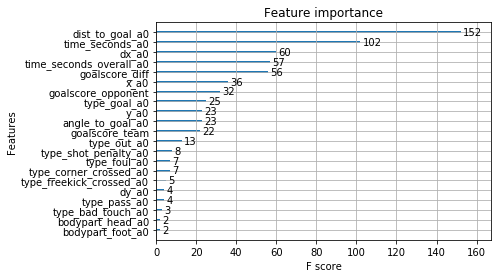

In [14]:
models["scores"]
xgboost.plot_importance(models["scores"])

### Save predictions

In [9]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id,"loading game ids"):
    Ai = pd.read_hdf(spadl_h5,f"actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A,Y_hat],axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions,desc="saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5,f"game_{int(k)}")

saving predictions per game: 100%|██████████| 64/64 [00:02<00:00, 27.57it/s]
